In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

In [2]:
ts = '20241108-123515'

fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
df = pd.read_csv(fpath)
# drop nans
df.dropna(inplace=True)
fpath = os.path.join(DATA_DIR,'processed',f'training_acs_df_{ts}.csv')
df_acs = pd.read_csv(fpath)
df_acs.set_index('Fips',inplace=True,drop=True)
# standardize
df_acs = (df_acs-df_acs.mean()) / df_acs.std()

### <font color=blue> Transform target (and target-affecting) variables.

In [3]:
county_transform = [x for x in df.columns if x.startswith('True_county_inc_deaths')]
county_transform += ['Naive_proj_deaths','Naive_true_deaths']
for var in county_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.Pop * 100000, axis=1)
    
state_transform = ['Proj_state_inc_deaths','True_state_inc_deaths']
for var in state_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.State_pop * 100000, axis=1)
    
display(df)

# add in census features
df = df.merge(df_acs,on='Fips')

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,...,True_county_inc_deaths_tm_6_x,True_county_inc_deaths_tm_7_x,True_county_inc_deaths_tm_8_x,True_county_inc_deaths_tm_9_x,True_county_inc_deaths_tm_10_x,True_county_inc_deaths_tm_11_x,Naive_proj_deaths_x,Naive_true_deaths_x,Proj_state_inc_deaths_x,True_state_inc_deaths_x
11,20200905,37,37001,169185,10367022,0.016320,157.0,205.0,46.0,0.0,...,1.182138,1.773207,0.591069,1.182138,1.182138,2.364276,2.105486,2.568493,1.524064,1.987070
12,20200912,37,37001,169185,10367022,0.016320,176.0,160.0,48.0,2.0,...,1.182138,1.182138,1.773207,0.591069,1.182138,1.182138,2.288760,2.134424,1.707337,1.553001
13,20200919,37,37001,169185,10367022,0.016320,157.0,187.0,48.0,0.0,...,0.591069,1.182138,1.182138,1.773207,0.591069,1.182138,2.105486,2.394866,1.524064,1.813443
14,20200926,37,37001,169185,10367022,0.016320,171.0,198.0,54.0,6.0,...,1.182138,0.591069,1.182138,1.182138,1.773207,0.591069,2.240530,2.500971,1.659107,1.919548
15,20201003,37,37001,169185,10367022,0.016320,171.0,189.0,56.0,2.0,...,1.773207,1.182138,0.591069,1.182138,1.182138,1.773207,2.240530,2.414158,1.659107,1.832735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,20220409,37,37199,18357,10367022,0.001771,55.0,43.0,51.0,0.0,...,5.447513,10.895026,10.895026,21.790053,10.895026,38.132592,5.978042,5.862290,0.540174,0.424423
9896,20220416,37,37199,18357,10367022,0.001771,41.0,76.0,51.0,0.0,...,10.895026,5.447513,10.895026,10.895026,21.790053,10.895026,5.842998,6.180607,0.405131,0.742740
9897,20220423,37,37199,18357,10367022,0.001771,60.0,29.0,51.0,0.0,...,5.447513,10.895026,5.447513,10.895026,10.895026,21.790053,6.026272,5.727246,0.588404,0.289379
9898,20220430,37,37199,18357,10367022,0.001771,33.0,42.0,51.0,0.0,...,5.447513,5.447513,10.895026,5.447513,10.895026,10.895026,5.765830,5.852644,0.327963,0.414777


### <font color=blue> How does training set size affect performance?

_Choose base "predictive" attributes_

In [27]:
# df.columns[:15]

In [50]:
BASE_PRED_COLS = ['True_state_inc_deaths_x']
# BASE_PRED_COLS = [x for x in df.filter(regex='True_county_inc_deaths_tm_._x').columns]
# BASE_PRED_COLS += ['True_state_inc_deaths_x']
# BASE_PRED_COLS += ['Naive_proj_deaths']

display(BASE_PRED_COLS)

['True_state_inc_deaths_x']

In [51]:
# l = BASE_PRED_COLS + [x for x in df_acs.columns]
# df[l]

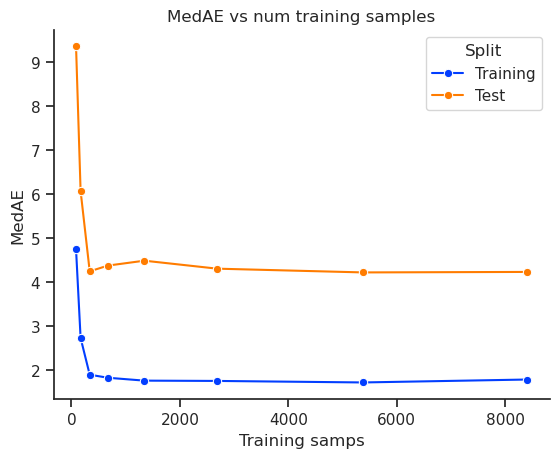

In [52]:
%precision %.2f
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True) # don't use scientific notation

from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
random.seed(666)

from tqdm.notebook import tqdm

target_col = 'True_county_inc_deaths_x'

num_weeks_in_chunk = 4

# ## Random split
# from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.1, 
#                                      random_state=666, shuffle=True)
## Temporal split
chunks = get_chunks(list(df.Date.unique()), num_weeks_in_chunk)
# idx = random.choice(range(len(chunks)))
idx = 5
df_train, df_test = get_date_chunked_splits(df, chunks, idx)

training_fracs = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.]

list_test_dfs = []
list_train_dfs = []
models = {}

for i,s in enumerate(training_fracs):
    
    dff_train = df_train.sample(frac=s,random_state=666)
    
    dff_test = df_test.copy()
    dff_train_for_eval = df_train.copy()
        
    feats =  BASE_PRED_COLS + [x for x in df_acs.columns] 
    X_train = dff_train[feats]
    y_train = dff_train[target_col]

    X_test = dff_test[feats]

    reg = LinearRegression().fit(X_train, y_train)

    dff_test[f'LinReg'] = reg.predict(X_test)
    dff_train_for_eval[f'LinReg'] = reg.predict(dff_train_for_eval[feats])

    list_test_dfs.append(dff_test)
    list_train_dfs.append(dff_train_for_eval)
    models[i] = reg
    
    
## GET PERFORMANCE !
from epsampling.modeling import get_metrics_ser

metrics_sers = []
for l,split in [[list_train_dfs,'Training'], [list_test_dfs,'Test']]:
    
    for i,dff in enumerate(l):
        ser = get_metrics_ser(dff, 
                              target_col='True_county_inc_deaths_x', 
#                               pred_col='LinReg_(True_state_inc_deaths_x)')
                              pred_col='LinReg')
        ser['Training frac'] = training_fracs[i]
        ser['Training samps'] = training_fracs[i] * len(df_train)
        ser['Split'] = split
        ## drop model attr bc only have one
        ser.pop('Model')
        metrics_sers.append(ser)

df_metrics = pd.DataFrame(metrics_sers)

## PLOT !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='bright') 
    
sns.lineplot(df_metrics, y='MedAE', x='Training samps', marker='o',hue='Split')
sns.despine()
plt.title(f'MedAE vs num training samples')
plt.show()

In [53]:
display(df_metrics[df_metrics.Split=='Training'],
        df_metrics[df_metrics.Split=='Test'])

,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training frac,Training samps,Split
0,788345770221.53,4.75,-61261992383594966810624.00,2903985807759281399791616.00,279893836749.66,290715680785.42,0.01,84.00,Training
1,526455228739.81,2.74,-60212882234158534885376.00,2854255120489707248549888.00,186912366901.52,194139165842.33,0.02,168.00,Training
2,15319588848.37,1.90,-185010382619414757376.00,8769997587586899509248.00,5439058167.32,5649354470.64,0.04,336.00,Training
3,1772015675.27,1.83,-6624174197063382016.00,314003954294319349760.00,629135443.95,653460401.33,0.08,672.00,Training
4,2.91,1.77,0.47,25.25,1.03,1.07,0.16,1344.00,Training
5,2.81,1.76,0.49,24.39,1.00,1.04,0.32,2688.00,Training
6,2.77,1.73,0.49,24.07,0.98,1.02,0.64,5376.00,Training
7,2.78,1.79,0.50,23.87,0.99,1.03,1.00,8400.00,Training


,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training frac,Training samps,Split
8,788345770223.83,9.36,-25904796782688731136000.00,2903985807758879283478528.00,133460035202.30,134982821997.68,0.01,84.00,Test
9,526455228742.13,6.08,-25461177759461460148224.00,2854255120492312683085824.00,89124259955.65,90141172966.37,0.02,168.00,Test
10,15319588850.96,4.25,-78232133464323932160.00,8769997587586363686912.00,2593472235.86,2623063905.52,0.04,336.00,Test
11,1772015678.24,4.38,-2801049716956979712.00,314003954291040845824.00,299986736.44,303409602.62,0.08,672.00,Test
12,6.03,4.49,0.21,88.18,1.02,1.03,0.16,1344.00,Test
13,5.85,4.31,0.23,86.83,0.99,1.00,0.32,2688.00,Test
14,5.84,4.23,0.21,88.02,0.99,1.00,0.64,5376.00,Test
15,5.86,4.24,0.22,87.92,0.99,1.00,1.00,8400.00,Test
